In [ ]:
import sys 
#sys.path.append('misc')
import numpy as np
import mdtraj as md
from scipy.spatial.distance import jensenshannon

#%conda activate trbme
import glob
from itertools import product
import sys
import glob
import numpy as np
from IPython.display import display, Math, Latex
from matplotlib import rcParams


import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
import mdtraj as md
from scipy.stats import norm as normal
from scipy.spatial.distance import jensenshannon
from scipy.stats import ks_2samp
#from kneed import KneeLocator, shape_detector
import kneefinder #TODO
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.transforms as mtransforms


from main_paper_figs_utils import *
import Go2SAXS as gs
sys.path.append('..')
import trBME as trbme
import BME as bme


In [2]:
main_fig_out_dir = './main_figures_pdf'
si_fig_out_dir = './appendix_figures_pdf'

# Analysis of Unbiased Simulations

In [3]:
# directories where to store the experimental observables, where synthetic experimental trajectories are located
# and where to store single frames for Pulchra
data_dir = '../'
exp_sim = data_dir+'/trajs/' #TODO add datapath  
exp_obs = exp_sim + 'obs/' #TODO add datapath  
exp_int = data_dir+ '/intensities/' #TODO add datapath  
av_int = data_dir+ '/average_intensities/' #TODO add datapath  
qfiles = '/Q' #TODO add datapath  
mdtrajs = '/md_' #TODO add datapath  

# cutoffs needed to detect unfoldings in MD simulations
max_cut = 0.9
min_cut = 0.6
eps = 0.03

# stride to read trajectories and topology to read them
stride = 50
top = data_dir+'/data/bsa_ca.pdb'

# bins for fram histograms
bins = 50

# number of experimental frames
nframes = 101

#dict for method results
rw = {}

#dict for comparison between different methods

method_comp_dict = {}

In [4]:
ntrajs = len(glob.glob(f'{exp_sim}/*.xtc'))
top_trj = md.load(top)
tmpq, tmpr, tmprm, qhist, rhist = [], [], [], [], []
for i in range(ntrajs):
    print("# PROCESSING {i}/{n}\r".format(i=i + 1, n=ntrajs), end="")
    colvars = gs.quick_load(f'{exp_obs}/{qfiles}{i}')[::stride] # load fraction of native contact files Q
    tmpq.append(colvars[:,1])
    traj = md.load(f'{exp_sim}/{mdtrajs}{i}.xtc', top=top, stride=stride) # load unfolding trajectory
    rg = md.compute_rg(traj) # compute the corresponding radius of gyration, Rg
    rmsd = md.rmsd(traj, top_trj)
    tmpr.append(rg)
    tmprm.append(rmsd)
# get Q and Rg stored as ntrajs x nframes, their averages and the corresponding stds
qexp, qav, qstd = convert(tmpq)
rgexp, rgav, rgstd = convert(tmpr)
rmexp, rmav, rmstd = convert(tmprm)
allq = np.concatenate(qexp)
allr = np.concatenate(rgexp)
allrmsd = np.concatenate(rmexp)

In [5]:
import os
os.listdir('../')

['figures',
 'trajs_old',
 'rw_results',
 'intensities',
 'BME',
 'average_intensities',
 'trajs',
 'ensemble_trajs',
 'data',
 'metad']

In [6]:
clustering = {}

icutmx = 0.835
icutmn = 0.675

def populations(q, icutmx, icutmn):
    '''Returns the populations of three states given two cutoffs'''
    U, I, F = [], [], []
    for i in q:
        uu, ii, ff, l = 0, 0, 0, len(i)
        for qq in i:
            if qq > icutmx:
                ff += 1./l
            elif qq < icutmx and qq > icutmn:
                ii += 1./l
            else:
                uu += 1./l
        U.append(uu)
        F.append(ff)
        I.append(ii)
        
    return np.array(U), np.array(I), np.array(F)

In [7]:
U, I, F = populations(qexp, icutmx, icutmn)
clustering['exp'] = [U, I, F]

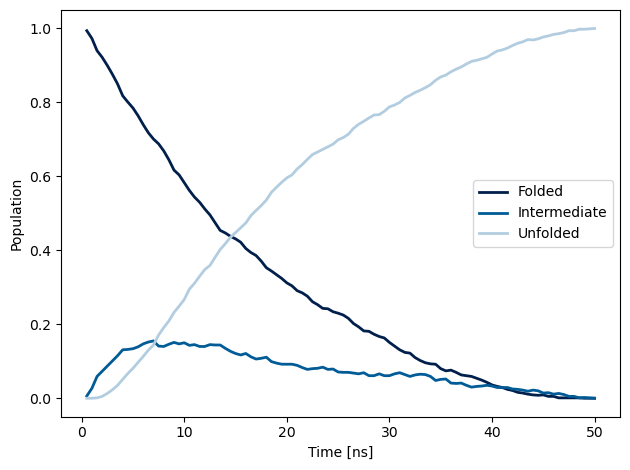

In [8]:
x = np.linspace(0, 50, nframes)

plt.plot(x[1:], F[1:], lw=2, c='#011f4b', label='Folded')
plt.plot(x[1:], I[1:], lw=2, c='#005b96', label='Intermediate')
plt.plot(x[1:], U[1:], lw=2, c='#b3cde0', label='Unfolded')
plt.xlabel('Time [ns]')
plt.ylabel('Population')
plt.legend()
plt.tight_layout()
#plt.savefig('pics/clustering.png', dpi=300)
plt.show()

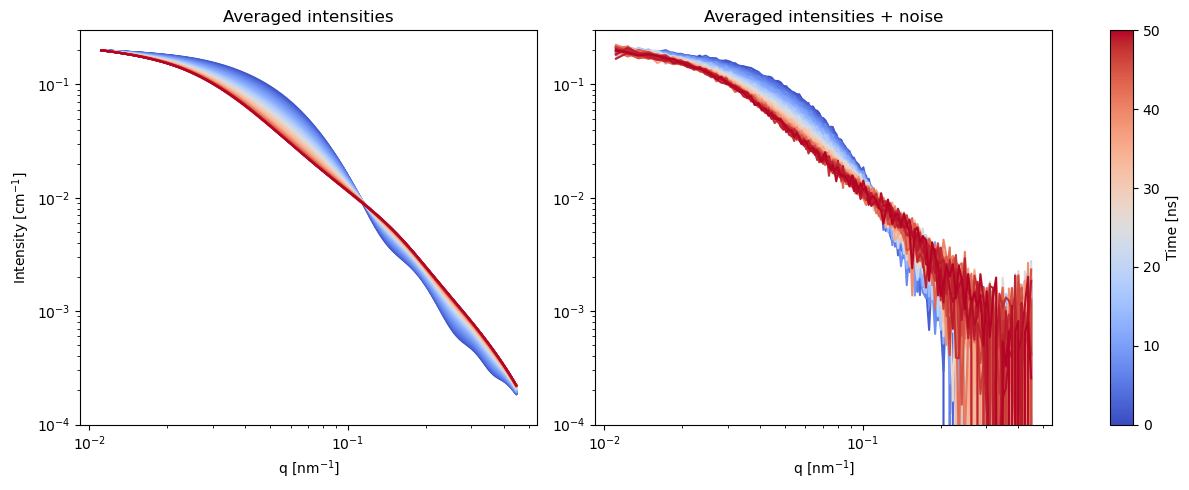

In [9]:
fig, ax = plt.subplots(1,3, figsize=(12,5), width_ratios=(1,1,0.05))
c = np.arange(0, 50.5, 0.5)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
cmap.set_array([])

ax[0].set_title("Averaged intensities")
for i in range(1,nframes):
    intensity = gs.quick_load( f"{av_int}/intensity_{i}.dat")
    ax[0].plot(intensity[:,0], intensity[:,1], c=cmap.to_rgba(i/2))  
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlabel('q [nm$^{-1}$]')
ax[0].set_ylabel(r'Intensity [cm$^{-1}$]')
ax[0].set_ylim((1e-4, 3e-1))

ax[1].set_title("Averaged intensities + noise")
for i in range(1,nframes):
    intensity = gs.quick_load( f"{exp_int}/intensity_{i}.dat")
    ax[1].plot(intensity[:,0], intensity[:,1], c=cmap.to_rgba(i/2))  
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel('q [nm$^{-1}$]')
ax[1].set_ylim((1e-4, 3e-1))
cax = ax[2]

cbar = plt.colorbar(cmap, cax=cax)
cbar.set_label(r'Time [ns]')

plt.tight_layout()
plt.show()
#plt.savefig('pics/saxs.pdf')


# Dynamical Prior (trBME)

In [10]:
data_dir = '../'

T = 161
key = 'dyn'
esaxs = data_dir+'/'+'intensities/'
top = data_dir+'/'+'data/bsa_ca.pdb'
metadir = data_dir+'/'+f'metad/161K/' #TODO Chat to correct datadir
msaxs = metadir + 'BME.dat'
bfile = metadir + f'WEIGHTS'
meta_trj = metadir + f'md.xtc'
thetas = [1, 2, 3, 4, 5, 10, 20, 25, 30, 35, 40, 45, 50, 55, 60, 100, 120, 150, 200, 250, 300, 400, 500, 600]
#thetas = [2, 3, 4, 5, 10, 20, 25, 30, 35, 40, 45, 50, 55, 60, 100, 120, 150, 200, 250, 300, 400, 500, 600]
#thetas = np.logspace(1,np.log(100), 20)


In [11]:
qmetad = np.genfromtxt(bfile)[:,1]
metad_trj = md.load(meta_trj, top=top)
rmetad = md.compute_rg(metad_trj)
top_trj = md.load(top)
rmsdmetad = md.rmsd(metad_trj, top_trj)


In [12]:
rw[key] = trbme.TimeResolvedBME(esaxs_dir=esaxs, meta_saxs=msaxs, bfile=bfile)
rw[key].save_results(data_dir+'/'+'rw_results/dyn.pkl')
#rw[key].load_results(data_dir+'/'+'rw_results/dyn.pkl')


In [13]:
rw[key].setup_fes(T)
x, fes_s1 = rw[key].get_fes()


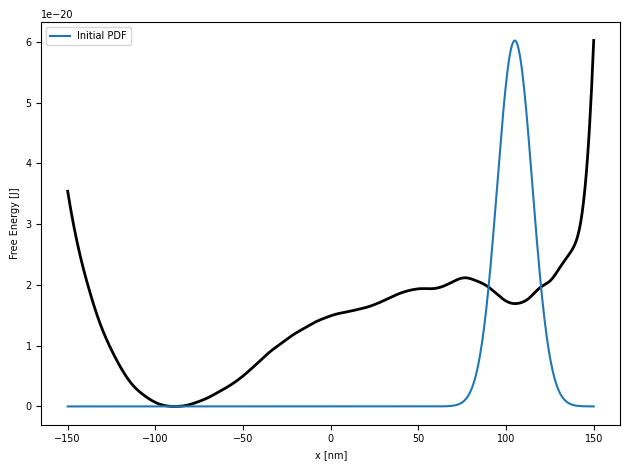

In [14]:
X = x/1e-9 #conversion in nm
mu = 105
sigma = 10
n = normal.pdf(X,mu,sigma)

plt.plot(X, fes_s1, c='k', lw=2)
plt.plot(X, n/np.max(n)*np.max(fes_s1), label='Initial PDF')
plt.xlabel('x [nm]')
plt.ylabel('Free Energy [J]')
plt.legend()
plt.tight_layout()


In [15]:
rw[key].fpsolve([mu,sigma], drag=1e-6, t=50, npriors=5000, temp=T)

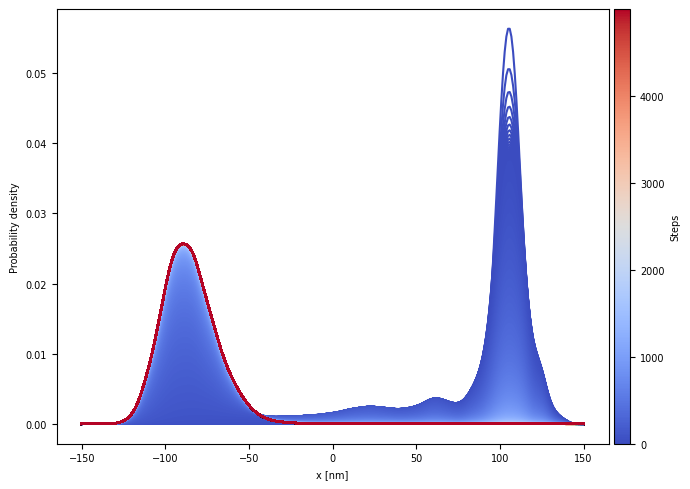

In [16]:
rw[key].plot_dynamical_priors()

In [17]:
rw[key].FP2weights()

### Optimise Fokker-Planck frames to experimental data, before reweighting 

In [18]:
chis = rw[key].optimise_priors_to_exp()

# PRE-COMPUTING PRIOR AVERAGES ...
# AVERAGE CHI2: 1.37


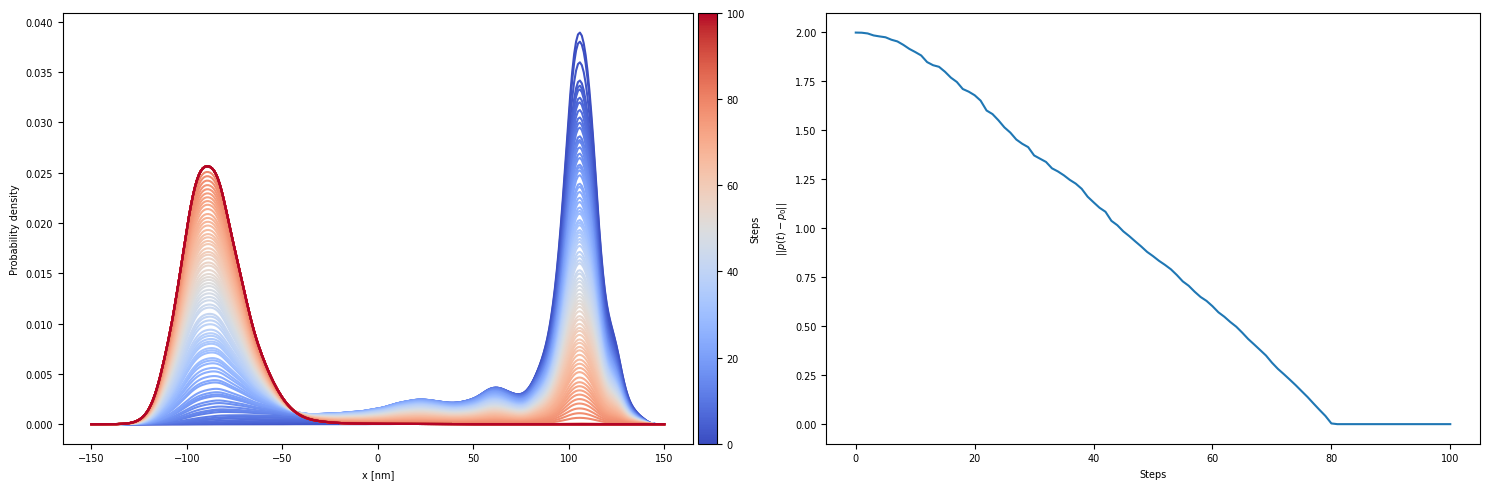

In [19]:
rw[key].plot_dynamical_priors(distance=True)
plt.show()

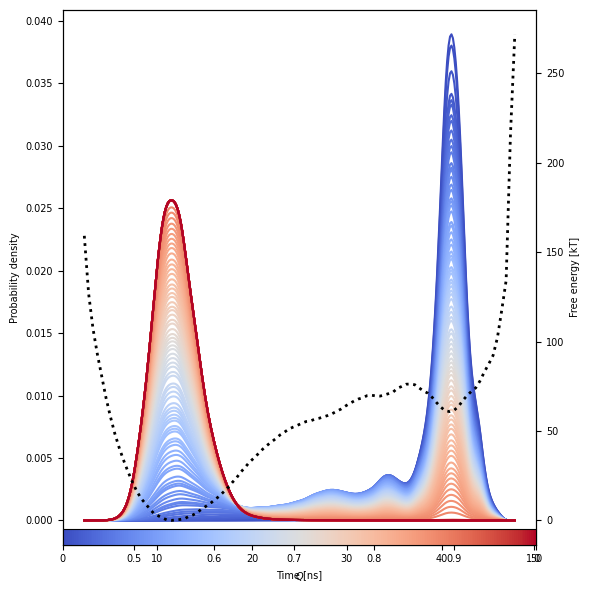

In [20]:
rw[key].plot_priors_with_fes(cv_label='$Q$', dt=0.5, outfig='dyn_priors.pdf')

In [21]:
rw[key].reweight(rw[key].priors, thetas)
rw[key].save_results(data_dir+'/'+'rw_results/dyn.pkl') #TODO

#rw[key].load_results(data_dir+'/'+'rw_results/dyn.pkl') #TODO


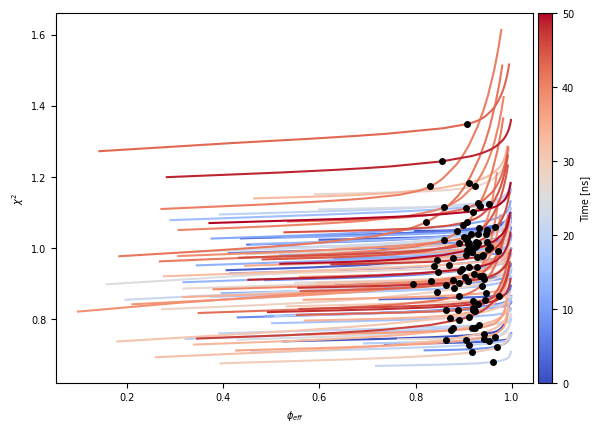

In [22]:
#rw[key].elbow_thetas()
#fixing elbow finder problem



def elbow_thetas(default_idx=None):
        """Use KneeLocator to find the location of the elbow in the phi-X^2 curve.

        Input
        -----
        default_idx (int): theta index to use in case no elbow is found. Default one is the theta in the middle
        of the provided range
        """
        #if not kneelib:
        #    raise ImportError("The kneed library is missing. Please, install it via: 'conda install -c conda-forge "
        #                      "kneed'.")
        if default_idx == None:
            default_idx = int(len(rw[key].res['phi'][0])/2)

        rw[key].theta_idxs = []
        top_val=1
        rw[key].opt_phi, rw[key].opt_x2i, rw[key].opt_x2f = [], [], []
        for i in range(nframes):

            kf = kneefinder.kneefinder.KneeFinder(rw[key].res['phi'][i][:-top_val], rw[key].res['x2f'][i][:-top_val])
            kf_x, kf_y = kf.find_knee()
            #plt.scatter(kf_idx,kf_y )
            #kneedle = KneeLocator(rw[key].res['phi'][i], rw[key].res['x2f'][i], curve=b, direction=a)
            idx = rw[key].res['phi'][i].index(kf_x)
            rw[key].theta_idxs.append(idx)
            #except ValueError:
            #    idx = default_idx
            #    rw[key].theta_idxs.append(idx)
            rw[key].opt_phi.append(rw[key].res['phi'][i][idx])
            rw[key].opt_x2i.append(rw[key].res['x2i'][i][idx])
            rw[key].opt_x2f.append(rw[key].res['x2f'][i][idx])
fig, ax = plt.subplots()

elbow_thetas()
c = np.arange(0, 50.4, 0.5)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
cmap.set_array([])
for i in range(1,101):
    ax.plot(rw[key].res['phi'][i], rw[key].res['x2f'][i], c=cmap.to_rgba(i/2), zorder=0)
    x = rw[key].res['phi'][i][rw[key].theta_idxs[i]]
    y = rw[key].res['x2f'][i][rw[key].theta_idxs[i]]
    ax.plot([x], [y], 'ko', markersize=4)
ax.set_xlabel(r'$\phi_{eff}$')
ax.set_ylabel(r'$\chi^2$')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.05)
cbar = plt.colorbar(cmap, cax=cax)
cbar.set_label(r'Time [ns]')
plt.savefig(si_fig_out_dir+'/dyn_phi_chi.pdf')
plt.show()

In [23]:
rw[key].res['phi']

[[1.2624877866013433e-08,
  2.8534101607973788e-08,
  6.734536414577685e-08,
  1.5089142735423774e-07,
  3.24700998475467e-07,
  9.48788139939261e-06,
  0.001274649283172887,
  0.005030832802828403,
  0.010076186214794875,
  0.014537740205606357,
  0.018792042302517183,
  0.023224905851937278,
  0.027981671617868784,
  0.03307738487546116,
  0.03851726027809271,
  0.09215970001331805,
  0.12351191551443222,
  0.17308461405233835,
  0.25638501964272353,
  0.33489528774502186,
  0.40574004682195974,
  0.5228634263887505,
  0.6115215483843796,
  0.6785707765346359],
 [0.5250438865747694,
  0.7432492005100262,
  0.8307739103704311,
  0.8740721184800503,
  0.8989861709211069,
  0.9424274138675828,
  0.9601378790923922,
  0.9636938709705172,
  0.9661522613669545,
  0.9680349834863624,
  0.9695894655647695,
  0.9708843012989808,
  0.9720176914250613,
  0.9730094362916832,
  0.9739000805819698,
  0.9790084030089055,
  0.980766409529603,
  0.9829323673436863,
  0.9856611983739028,
  0.987703696

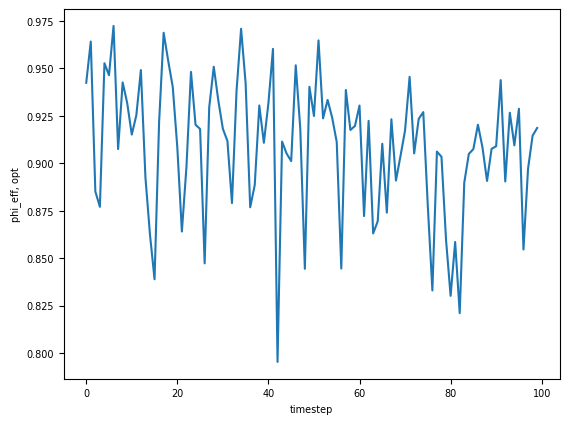

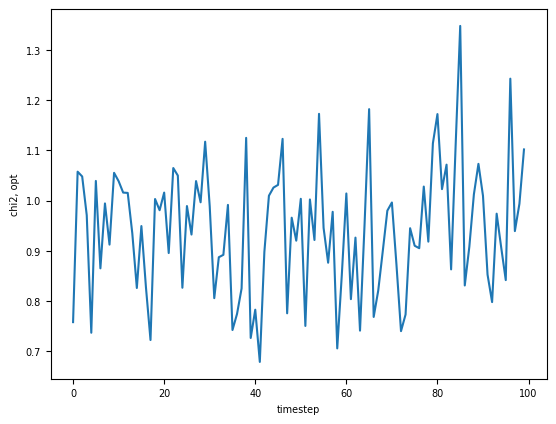

In [24]:
#plt.plot(np.arange(len(thetas)), thetas)
opt_phis = [rw['dyn'].res['phi'][i][rw[key].theta_idxs[i]] for i in range(101)]
opt_chis = [rw['dyn'].res['x2f'][i][rw[key].theta_idxs[i]] for i in range(101)]

plt.plot(opt_phis[1:])
plt.xlabel('timestep')
plt.ylabel('phi_eff, opt')

plt.show()
plt.plot(opt_chis[1:])
plt.xlabel('timestep')
plt.ylabel('chi2, opt')

plt.show()

In [25]:
#load SAXS data
data = np.loadtxt(msaxs)
#load histograms along different CVs 
bins = 50
histq = rw[key].pdens_per_frame(qmetad, rw[key].theta_idxs, rw[key].priors, bins=bins)
histr = rw[key].pdens_per_frame(rmetad, rw[key].theta_idxs, rw[key].priors, bins=bins)
histm = rw[key].pdens_per_frame(rmsdmetad, rw[key].theta_idxs, rw[key].priors, bins=bins)




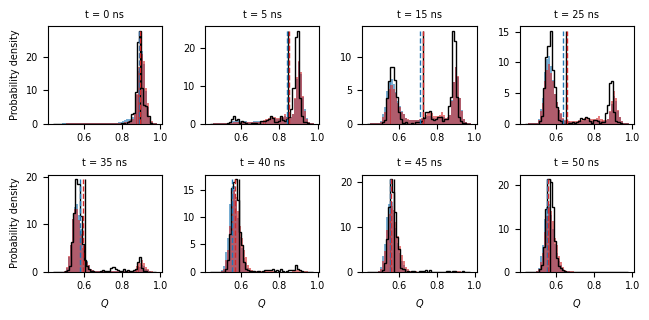

In [26]:
frames = [1,10,30,50,70,80,90,100]
label = '$Q$'
plot_histograms(qmetad, frames, bins, histq, qexp, qav, label, outfig=si_fig_out_dir+'/dyn_hist_q.pdf', prior_dim=2)

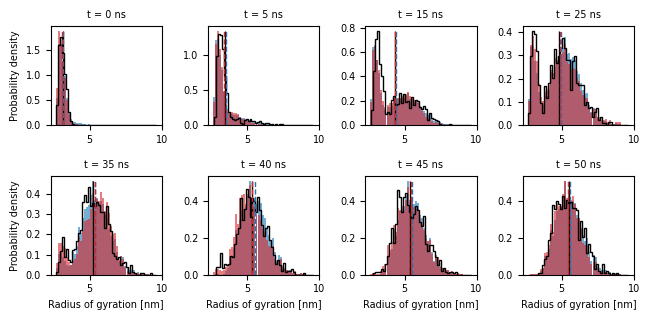

In [27]:
frames = [1,10,30,50,70,80,90,100]
label = 'Radius of gyration [nm]'
plot_histograms(rmetad, frames, bins, histr, rgexp, rgav, label, outfig=si_fig_out_dir+'/dyn_rg_hist.pdf', prior_dim=2)

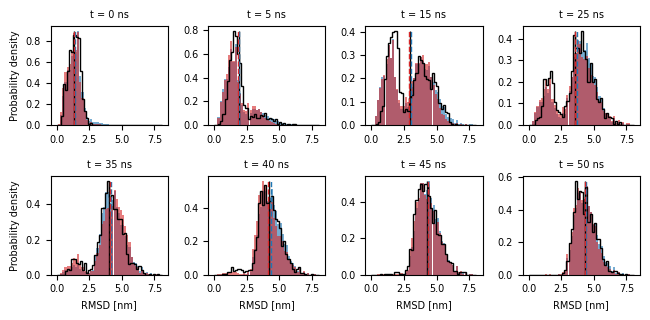

In [28]:
frames = [1,10,30,50,70,80,90,100]
label = 'RMSD [nm]'
plot_histograms(rmsdmetad, frames, bins, histm, rmexp, rmav, label, outfig=si_fig_out_dir+'/dyn_rmsd_hist.pdf', prior_dim=2) 

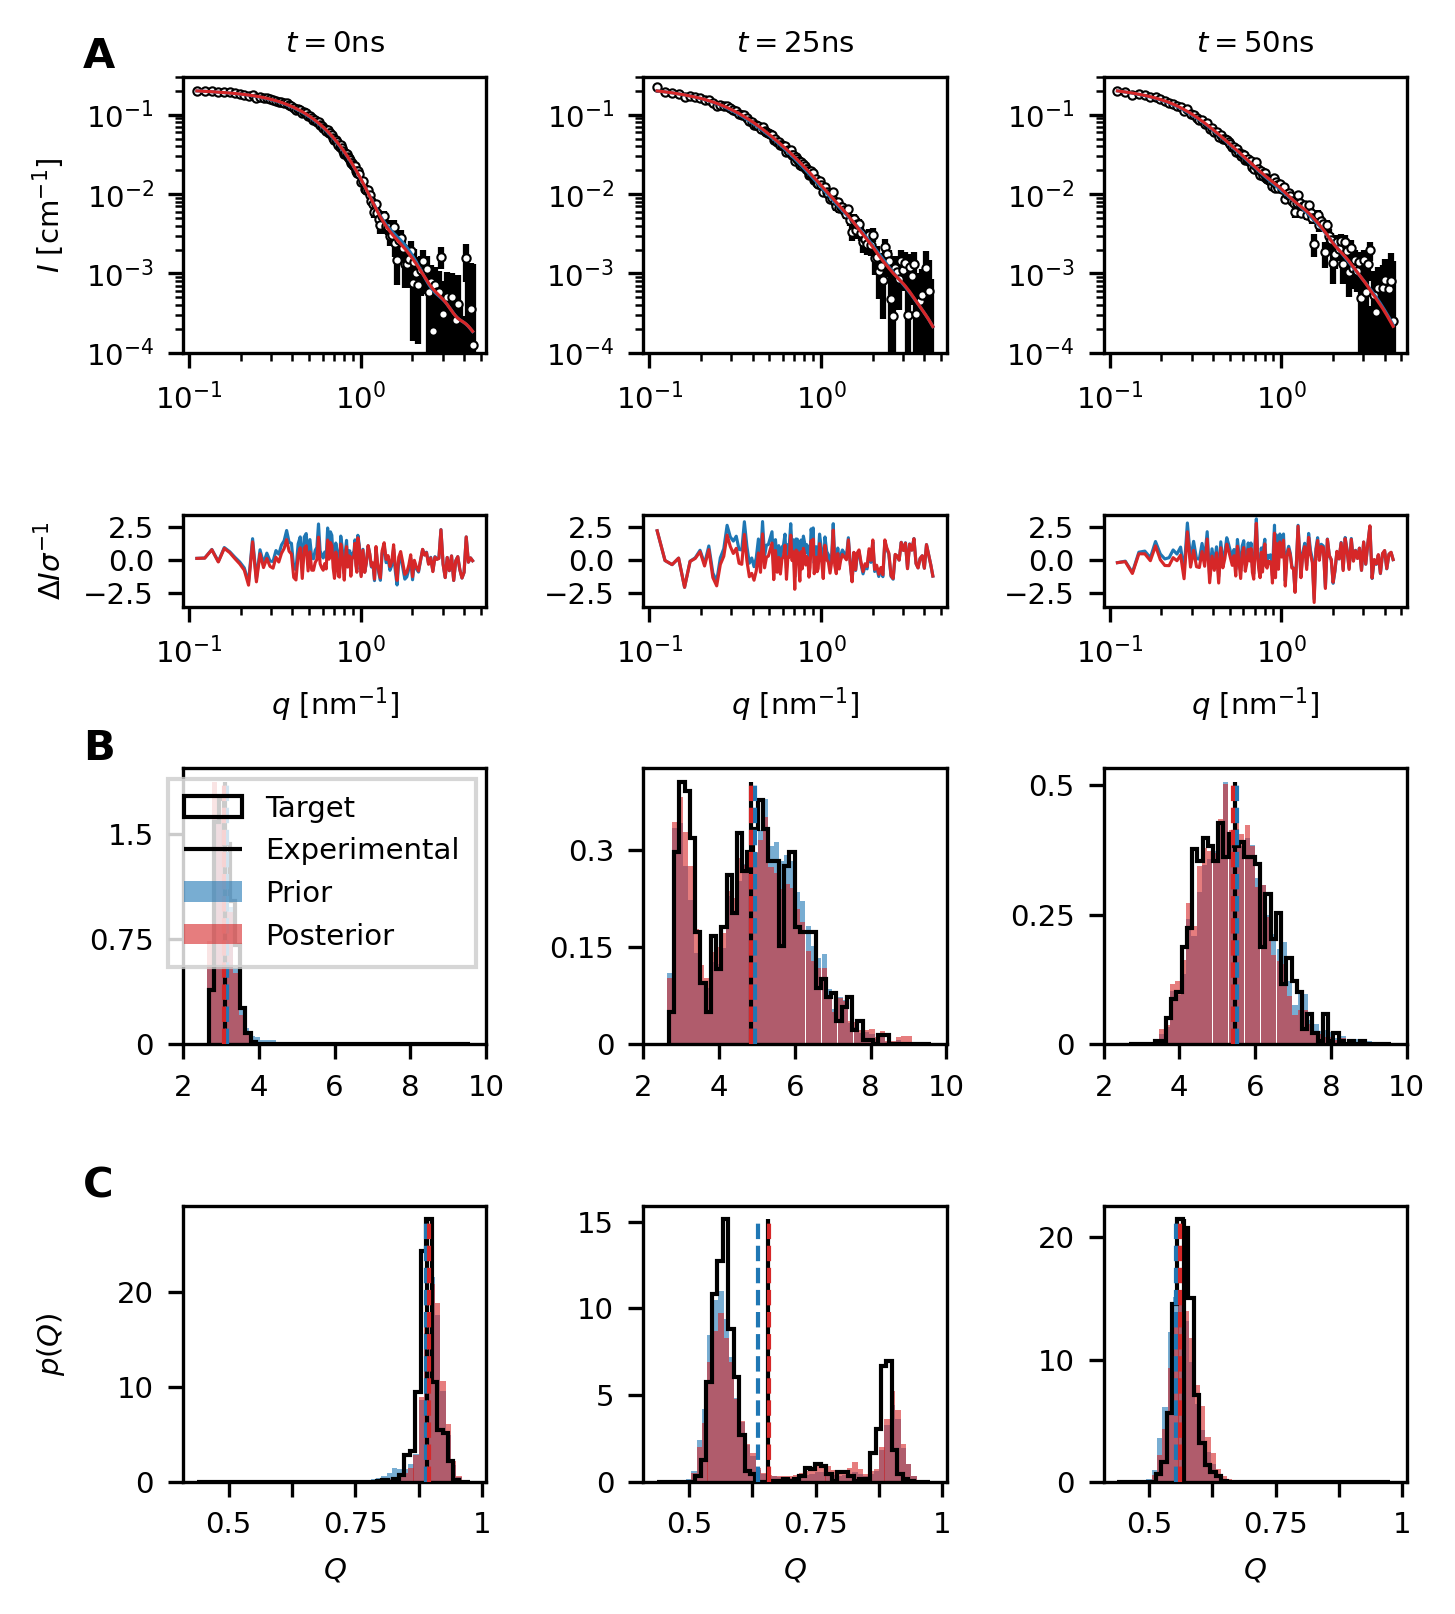

In [29]:
#style_path = "/Users/vjc493/Documents/mpl_style/custom.mplstyle"
#plt.style.use(style_path)


def plot_performance_1():
    fig = plt.figure(figsize=(1.5*3.3,2*3.3),dpi=300)#,height_ratio=(1,0.5,1,1))
                    #constrained_layout=True)#, tight_layout=True)#constrained_layout=True)#(7.4,7.4/1.5),dpi=300,constrained_layout=True)

    frames = [1, 50, 100]

    gspec = fig.add_gridspec(5, 3, height_ratios=[0.3,0.1,0.3, 0.3, 0.3] )
    ax0 = fig.add_subplot(gspec[0, 0])
    ax1 = fig.add_subplot(gspec[0, 1], sharey=ax0)
    ax2 = fig.add_subplot(gspec[0, 2],sharey=ax0)

    #ax3_inv = fig.add_subplot(gspec[2, 0])
    #ax4_inv = fig.add_subplot(gspec[2, 1])
    #ax5_inv = fig.add_subplot(gspec[2, 2])
    
    #[aks.set_visible(False) for aks in [ax3_inv, ax4_inv, ax5_inv]]
    
    ax3 = fig.add_subplot(gspec[1, 0])
    ax4 = fig.add_subplot(gspec[1, 1],sharey=ax3)
    ax5 = fig.add_subplot(gspec[1, 2],sharey=ax3)

    ax6 = fig.add_subplot(gspec[3, 0])
    ax7 = fig.add_subplot(gspec[3, 1])
    ax8 = fig.add_subplot(gspec[3, 2])

    ax9 = fig.add_subplot(gspec[2, 0])
    ax10 = fig.add_subplot(gspec[2, 1])
    ax11 = fig.add_subplot(gspec[2, 2])

    ax_arr = [[ax0,ax3,ax6,ax9],[ax1,ax4,ax7,ax10],[ax2,ax5,ax8,ax11]]



    for i,f,ax_plot_arr in zip(np.arange(3),frames,ax_arr):
        intensity = gs.quick_load( f"{exp_int}/intensity_{f}.dat")
        #plt.plot(intensity[:,0], intensity[:,1], c=cmap.to_rgba(i/2))  
        plot_saxs_fits(ax_plot_arr[0], data,intensity, np.array(rw["dyn"].res['w'])[f,0,:], rw["dyn"].priors[:,f],
                        residuals=True, res_ax=ax_plot_arr[1])#, outfig='metad_saxs.png')
        plot_histograms_ax(qmetad, [f], bins, histq, qexp, qav, label, prior_dim=2, hist_ax=ax_plot_arr[2], outfig=None)
        plot_histograms_ax(rmetad, [f], bins, histr, rgexp, rgav, label ,prior_dim=2,hist_ax=ax_plot_arr[3], outfig=None)
        #ax[3,i].set_yscale('log')

    #[ax_val.grid() for ax_val in [ax0,ax1,ax2, ax3, ax4, ax5]]
    #[ax_val.set_yticklabels([]) for ax_val in [ax1,ax2,ax4, ax5 ]]
    #[ax_val.set_xticklabels([]) for ax_val in [ax0,ax1,ax2]]
    
    [ax_val.set_xticks([0.5,0.625,0.75,0.875, 1], ['0.5','', '0.75','', '1']) for ax_val in [ax6,ax7,ax8]]
    [ax_val.set_xticks([2,4,6, 8,10], ["2","4","6", "8","10"]) for ax_val in [ax9,ax10,ax11]]
    [ax_val.set_yticks([1e-1,1e-2,1e-3,1e-4]) for ax_val in [ax0,ax1,ax2]]
    [ax_val.set_xlabel(r'$Q$') for ax_val in [ax6,ax7,ax8] ]
    #[ax_val.set_xlabel(r'$R_{\textsf{g}}$ [nm]') for ax_val in [ax9,ax10,ax11] ]
    [ax_val.set_xlabel(r'$q$ [nm$^{-1}$]') for ax_val in [ax3,ax4,ax5] ]

    ax9.set_yticks([0,0.75,1.5], [0,0.75,1.5])
    ax10.set_yticks([0,0.15,0.3], [0,0.15,0.3])
    ax11.set_yticks([0,0.25,0.5], [0,0.25,0.5])

    #ax6.set_yticks([0,10,20], ['0','','20'])
    #ax7.set_yticks([0,7.5,15], ['0','','15'])
    #ax8.set_yticks([0,10,20], ['0','','20'])
    #for i,f,ax_plot_arr in zip(np.arange(3),frames,ax_arr):
    #    ax_plot_arr[0].text(1.2e-1,1.7e-4 ,r'$\chi^2_{\textsf{R}}(\bm{w}_t)=$'+str(np.round(rw['dyn'].res['x2f'][f][rw['dyn'].theta_idxs[f]],2))+'\n'
    #             +r'$\chi^2_{\textsf{R}}(\bm{w}_t^0)=$'+str(np.round(rw['dyn'].res['x2i'][f][0],2))+
    #            '\n'+r'$\phi_{\textsf{eff}}$='+ str(np.round(rw['dyn'].res['phi'][f][rw['dyn'].theta_idxs[f]],2))+
    #            '\n'+r'$\theta$='+ str(np.round(thetas[rw['dyn'].theta_idxs[f]],2)))#, bbox=dict(facecolor='w', edgecolor='0.8', boxstyle='square,pad=0.15'))

    
    #[ax_val.set_yticks([0.5,0.75, 1], ['0.5', '0.75', '1']) for ax_val in [ax6,ax7,ax8]]
    ax3.set_ylabel(r'$\Delta I\sigma^{-1}$')
    ax0.set_ylabel(r'$I$ [cm$^{-1}$]')

    ax6.set_ylabel(r'$p(Q)$')

    #ax9.set_ylabel(r'$p(R_{\textsf{g}})$', )
    ax0.set_title(r'$t= 0$ns', fontsize=7)
    ax1.set_title(r'$t= 25$ns', fontsize=7)
    ax2.set_title(r'$t=50$ns', fontsize=7)
    
    [ax_val.set_ylim((1e-4, 3e-1)) for ax_val in [ax0,ax1,ax2] ]

    
    #label_s = [r'\textsf{\textbf{A}}', r'\textsf{\textbf{B}}', r'\textsf{\textbf{C}}', ]

    
    
    leg = ax9.legend(facecolor='w', edgecolor='0.8',fontsize=7 )
    leg.get_frame().set_boxstyle('square,pad=0.15')
    fig.align_ylabels()
    fig.tight_layout()
    label_s = ['A', 'B', 'C', 'D']
    for lab, aks in zip(label_s, [ax0, ax9, ax6]):
        # label physical distance to the left and up:
        #trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
        trans = mtransforms.ScaledTranslation(-24/72, 0/72, fig.dpi_scale_trans)

        aks.text(0.0, 1.0, lab, transform=aks.transAxes + trans,
                va='bottom', fontsize=10, 
                fontweight='bold')
    

    plt.savefig('main_figures_pdf/performance_1_v3.pdf')
    plt.show()
    
plot_performance_1()

In [30]:
U, I, F = rw['dyn'].populations(qmetad, icutmx, icutmn, rw['dyn'].res['w'], rw['dyn'].theta_idxs)
clustering['dyn'] = [U, I, F]

In [31]:
pr_dist = []
rw_dist = []
for i,t in enumerate(np.linspace(0,50, nframes)):
    if i==0: continue
    he = np.histogram( qexp[i], bins = 50, density = True,range=(qmetad.min(),qmetad.max()) ) 
#                 linewidth = 2, color = 'k', zorder=3, range=(obs.min(),obs.max()) )
    dist_q = distances(histq['hrw'][i],he[0])
    #plt.scatter(t,dist_q['js'], color = 'tab:red')
    rw_dist.append(dist_q['js'])
    
    he = np.histogram( qexp[i], bins = 50, density = True,range=(qmetad.min(),qmetad.max()) ) 
#                 linewidth = 2, color = 'k', zorder=3, range=(obs.min(),obs.max()) )
    dist_q = distances(histq['hpr'][i], he[0])
    #plt.scatter(t,dist_q['js'], color = 'tab:blue')
    pr_dist.append(dist_q['js'])
method_comp_dict['dyn'] = {'prior':pr_dist, 'post':rw_dist}  


## Equilibrium Prior

In [32]:
T = 161
key = 'metad'
esaxs =data_dir+'/'+ 'intensities/'
top =data_dir+'/'+ 'data/bsa_ca.pdb'
metadir = data_dir+'/'+f'metad/161K/'
msaxs = metadir + 'BME.dat'
bfile = metadir + f'WEIGHTS'
meta_trj = metadir + f'md.xtc'
thetas = [1, 2, 3, 4, 5, 10, 20, 25, 30, 35, 40, 45, 50, 55, 60, 100, 120, 150, 200, 250, 300, 400, 500, 600]

Load fraction of Go-contacts and compute Rg from simulation

In [33]:
qmetad = np.genfromtxt(bfile)[:,1]
metad_trj = md.load(meta_trj, top=top)
rmetad = md.compute_rg(metad_trj)
top_trj = md.load(top)
rmsdmetad = md.rmsd(metad_trj, top_trj)

### Reweighting

We run the reweighting routine using the constant (MetaD reconstructed) equilibrium weights as prior. This prior is automatically generated by the class.m

In [34]:
rw[key] = trbme.TimeResolvedBME(esaxs_dir=esaxs, meta_saxs=msaxs, bfile=bfile)
#rw[key] = trbme.TimeResolvedBME(esaxs_dir=esaxs, meta_saxs=msaxs, bfile=bfile)
rw[key].reweight(rw[key].w0, thetas)
#rw['metad'].save_results('rw_results/metad')
#rw['metad'].load_results(data_dir+'/'+'rw_results/metad.pkl')

/maps/projects/dynaplix/people/vjc493/trbme/trBME_for_github/figures/../BME/BME.py:325: RuntimeWarning: overflow encountered in exp
  w_opt = self.w0*np.exp(arg)
/maps/projects/dynaplix/people/vjc493/trbme/trBME_for_github/figures/../BME/BME.py:326: RuntimeWarning: invalid value encountered in divide
  w_opt /= np.sum(w_opt)


Let's check the behaviour of $\phi_{eff}$ against $\chi^2$ for every frame. Since there is no evident optimal way to select $\theta$, we arbitrarly select $\theta=50$ for every frame. As it will become clear later, this does not impact the conclusions we will reach. 

<Figure size 1000x700 with 0 Axes>

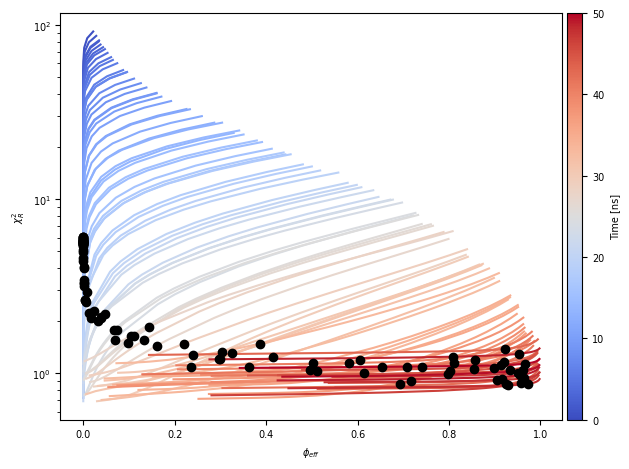

In [35]:
plt.figure(figsize=(10,7))
theta_idxs = [thetas.index(50)]*nframes
c = np.arange(0, 50.5, 0.5)
plot_xphi_frames(rw['metad'], theta_idxs, c, outfile='phi_chi_metad.png')
rw['metad'].thetas = np.ones(101)*50
rw['metad'].theta_idxs = theta_idxs

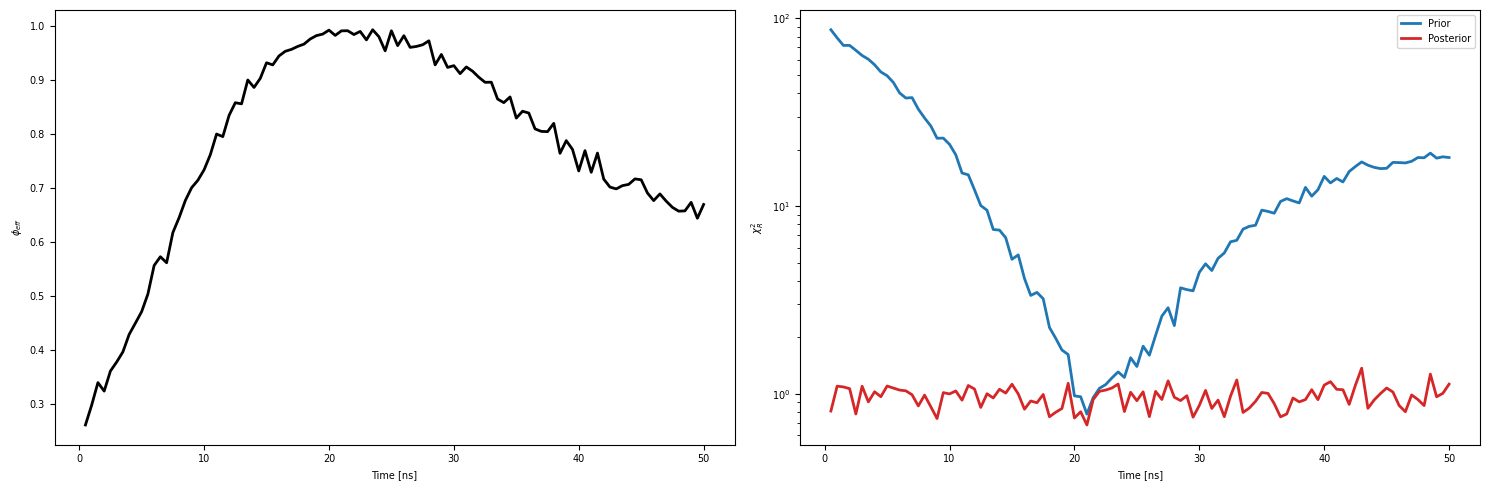

In [62]:
phi_metad, x2i_metad, x2f_metad = plot_xphi(rw[key], theta_idxs, c, outfig=None)

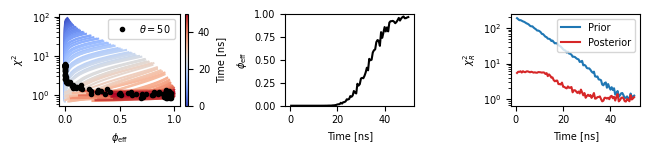

In [37]:
fig, ax = plt.subplots(1,3,figsize=(6.6, 6.6/4))
c = np.arange(0, 50.4, 0.5)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
cmap.set_array([])
for i in range(1,101):
    ax[0].plot(rw['metad'].res['phi'][i], rw['metad'].res['x2f'][i], c=cmap.to_rgba(i/2), zorder=0)
    x = phi_metad[i]
    y = x2f_metad[i]
    ax[0].plot([x], [y], 'k.',label=r'$\theta=50$')
    if i==1:
        ax[0].legend()
ax[0].set_xlabel(r'$\phi_{\text{eff}}$')
ax[0].set_ylabel(r'$\chi^2$')
ax[0].set_yscale('log')

divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='3%', pad=0.05)
cbar = plt.colorbar(cmap, cax=cax)
cbar.set_label(r'Time [ns]')

ax[1].plot(c[1:], phi_metad[1:], c='k')
ax[1].set_xlabel('Time [ns]')
ax[1].set_ylim(0,1)
ax[1].set_ylabel(r'$\phi_{\text{eff}}$')

ax[2].plot(c[1:],x2i_metad[1:], c='tab:blue', label='Prior')
ax[2].set_xlabel('Time [ns]')
ax[2].plot(c[1:],x2f_metad[1:], c='tab:red', label='Posterior')
ax[2].set_yscale('log')
ax[2].set_ylabel(r'$\chi^2_R$')
ax[2].legend(fontsize=7)

plt.tight_layout()
#plt.savefig('appendix_figs_new/stats_metad_prior.pdf')

(101, 1000)


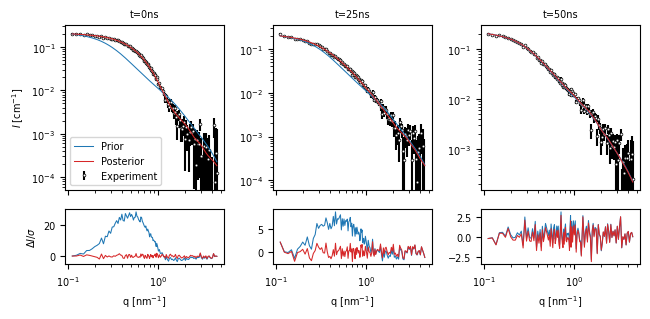

In [38]:
frames = [1,50, 100]
fig,ax = plt.subplots(2,len(frames), figsize=(6.6, 3.3), sharex=True,gridspec_kw={'height_ratios': [3, 1]})
#thidx = [thetas.index(50)]*3
thidx=None
#rw[key].plot_saxs_fits(frames, thidx, rw[key].w0, outfig='metad_saxs.png')
#exp_data = np.vstack((qexp, qav, qstd)).T
print(qexp.shape)
#    plt.plot(intensity[:,0], intensity[:,1], c=cmap.to_rgba(i/2)) ,data, rw[key].res['w'], rw[key].w0)#, outfig='metad_saxs.png')
for i,f in enumerate(frames):
    intensity = gs.quick_load( f"{exp_int}/intensity_{f}.dat")
    #plt.plot(intensity[:,0], intensity[:,1], c=cmap.to_rgba(i/2))  
    plot_saxs_fits(ax[0,i], data,intensity, np.array(rw["metad"].res['w'])[f,0,:],
                w0=rw["metad"].w0,
                residuals=True, res_ax=ax[1,i])
ax[1,0].set_ylabel(r'$\Delta I/\sigma$')
ax[0,0].set_ylabel(r'$I$ [cm$^{-1}$]')
ax[0,0].legend()
[ax[0,i].set_title(f't={int(frames[i]/2)}ns') for i in range(3)]
#def plot_saxs_fits(data, exp, w, w0):
plt.tight_layout()
plt.savefig('saxs_fits_metad_prior.pdf')
plt.show()
#__exp_ints

In [39]:
bins = 50
histq_metad = rw[key].pdens_per_frame(qmetad, theta_idxs, rw[key].w0, bins=bins)
histr_metad = rw[key].pdens_per_frame(rmetad, theta_idxs, rw[key].w0, bins=bins)
histm_metad = rw[key].pdens_per_frame(rmsdmetad, theta_idxs, rw[key].w0, bins=bins)

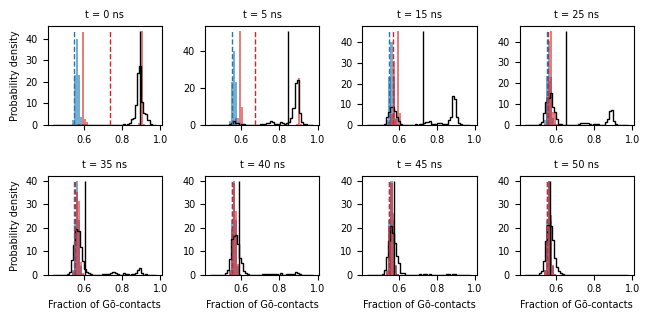

In [40]:
frames = [1,10,30,50,70,80,90,100]
label = 'Fraction of Gō-contacts'
plot_histograms(qmetad, frames, bins, histq_metad, qexp, qav, label, 'histq_metad.pdf', prior_dim=0)

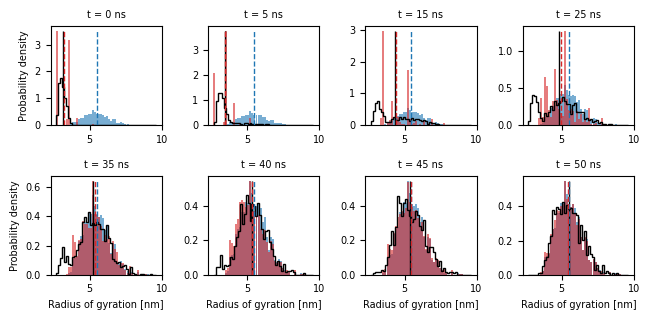

In [41]:
frames = [1,10,30,50,70,80,90,100]
label = 'Radius of gyration [nm]'
plot_histograms(rmetad, frames, bins, histr_metad, rgexp, rgav, label, si_fig_out_dir+'/hist_rg_metad_prior.pdf', prior_dim=0)

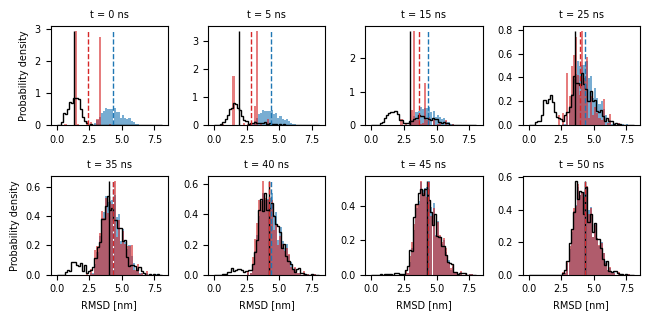

In [42]:
frames = [1,10,30,50,70,80,90,100]
label = 'RMSD [nm]'
plot_histograms(rmsdmetad, frames, bins, histm_metad, rmexp, rmav, label, outfig=si_fig_out_dir+'/hist_rmsd_metad_prior.pdf', prior_dim=0)

In [43]:
#populations
U, I, F = rw['metad'].populations(qmetad, icutmx, icutmn, rw['metad'].res['w'], theta_idxs)
clustering['metad'] = [U, I, F]
#plot_populations(clustering, 'uniform', 'Uniform')

In [44]:
pr_dist = []
rw_dist = []
for i,t in enumerate(np.linspace(0,50, nframes)):
    if i==0: continue
    he = np.histogram( qexp[i], bins = 50, density = True,range=(qmetad.min(),qmetad.max()) ) 
#                 linewidth = 2, color = 'k', zorder=3, range=(obs.min(),obs.max()) )
    dist_q_rw = distances(histq_metad['hrw'][i],he[0])
    #plt.scatter(t,dist_q['js'], color = 'tab:red')
    rw_dist.append(dist_q_rw['js'])
    #print(len(rw_dist))
    he = np.histogram( qexp[i], bins = 50, density = True,range=(qmetad.min(),qmetad.max()) ) 
#                 linewidth = 2, color = 'k', zorder=3, range=(obs.min(),obs.max()) )
    dist_q_pr = distances(histq_metad['hpr'][0], he[0])
    #plt.scatter(t,dist_q['js'], color = 'tab:blue')
    pr_dist.append(dist_q_pr['js'])
    #print(len(pr_dist))

method_comp_dict['metad'] = {'prior':pr_dist, 'post':rw_dist}  


In [45]:
rmsf = []
for i in range(1,101):
    traj1 = md.load(data_dir+'/'+f'ensemble_trajs/md_{i}.xtc', top=data_dir+'/'+'data/bsa_ca.pdb')
    rmsf_md = md.rmsf(traj1, top_trj)
    rmsf_metad = weighted_rmsf(metad_trj, top_trj, rw['metad'].res['w'][i][rw['metad'].theta_idxs[i]])
    rmsf_diff = np.average(np.fabs(rmsf_md - rmsf_metad)/rmsf_md * 100)
    rmsf.append(rmsf_diff)
av_rmsf = np.average(rmsf)
err_rmsf = np.std(rmsf)/np.sqrt(len(rmsf))

tmpq = np.fabs(qav - histq['avrw'])/qav * 100
tmpr = np.fabs(rgav - histr['avrw'])/rgav * 100
tmpm = np.fabs(rmav[1:] - histm['avrw'][1:])/rmav[1:] * 100
diff_avq = np.average(tmpq)
diff_errq = np.std(tmpq)/np.sqrt(len(tmpq))
diff_avr = np.average(tmpr)
diff_errr = np.std(tmpr)/np.sqrt(len(tmpr))
diff_avm = np.average(tmpm)
diff_errm = np.std(tmpm)/np.sqrt(len(tmpm))

averages_dyn = {'Rg':[diff_avr, diff_errr], 'Q':[diff_avq, diff_errq], 'RMSD':[diff_avm, diff_errm],
                 'RMSF':[av_rmsf, err_rmsf]}

print("# dynamical POSTERIOR")
print("# ---------------")
print(f"# Delta <Rg>:   {diff_avr:.1f} +- {diff_errr:.1f}%")
print(f"# Delta <Q>:    {diff_avq:.1f} +- {diff_errq:.1f}%")
print(f"# Delta <RMSD>: {diff_avm:.0f} +- {diff_errm:.0f}%")
print(f"# Delta <RMSF>: {av_rmsf:.0f} +- {err_rmsf:.0f}%")

# dynamical POSTERIOR
# ---------------
# Delta <Rg>:   0.9 +- 0.1%
# Delta <Q>:    1.0 +- 0.1%
# Delta <RMSD>: 2 +- 0%
# Delta <RMSF>: 16 +- 3%


## Uniform prior

In [46]:
T = 161
key = 'uniform'
esaxs = data_dir+'/'+'intensities/'
top = data_dir+'/'+'data/bsa_ca.pdb'
metadir = data_dir+'/'+f'metad/161K/'
msaxs = metadir + 'BME.dat'
bfile = metadir + f'WEIGHTS'
meta_trj = metadir + f'md.xtc'
thetas = [1, 2, 3, 4, 5, 10, 20, 25, 30, 35, 40, 45, 50, 55, 60, 100, 120, 150, 200, 250, 300, 400, 500, 600]

In [47]:
rw[key] = trbme.TimeResolvedBME(esaxs_dir=esaxs, meta_saxs=msaxs, bfile=bfile)

### Reweighting

In [48]:
l = len(rw[key].w0)
w0 = np.ones(l)/l

rw[key].reweight(w0, thetas)
#rw[key].save_results('rw_results/uniform')
#rw[key].load_results('rw_results/uniform.pkl')

Select $\theta_t$ in the $\phi_{eff}$-$\chi^2_R$ elbow

In [49]:
rw[key].elbow_thetas()


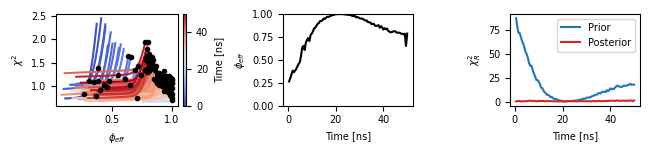

In [50]:
fig, ax = plt.subplots(1,3,figsize=(6.6, 6.6/4))
c = np.arange(0, 50.4, 0.5)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
cmap.set_array([])
for i in range(1,101):
    ax[0].plot(rw['uniform'].res['phi'][i], rw['uniform'].res['x2f'][i], c=cmap.to_rgba(i/2), zorder=0)
    x = rw['uniform'].res['phi'][i][rw['uniform'].theta_idxs[i]]
    y = rw['uniform'].res['x2f'][i][rw['uniform'].theta_idxs[i]]
    ax[0].plot([x], [y], 'k.',)
ax[0].set_xlabel(r'$\phi_{{eff}}$')
ax[0].set_ylabel(r'$\chi^2$')

divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='3%', pad=0.05)
cbar = plt.colorbar(cmap, cax=cax)
cbar.set_label(r'Time [ns]')

ax[1].plot(c[1:], rw[key].opt_phi[1:], c='k')
ax[1].set_xlabel('Time [ns]')
ax[1].set_ylim(0,1)
ax[1].set_ylabel(r'$\phi_{{eff}}$')

ax[2].plot(c[1:], rw['uniform'].opt_x2i[1:], c='tab:blue', label='Prior')
ax[2].set_xlabel('Time [ns]')

ax[2].plot(c[1:], rw['uniform'].opt_x2f[1:], c='tab:red', label='Posterior')
ax[2].set_ylabel(r'$\chi^2_R$')
ax[2].legend(fontsize=7)

plt.tight_layout()
plt.savefig(si_fig_out_dir+'/stats_uniform_prior.pdf')

In [51]:
bins = 50
histq_uni = rw[key].pdens_per_frame(qmetad, rw[key].theta_idxs, w0, bins=bins)
histr_uni = rw[key].pdens_per_frame(rmetad, rw[key].theta_idxs, w0, bins=bins)
histm_uni = rw[key].pdens_per_frame(rmsdmetad, rw[key].theta_idxs, w0, bins=bins)

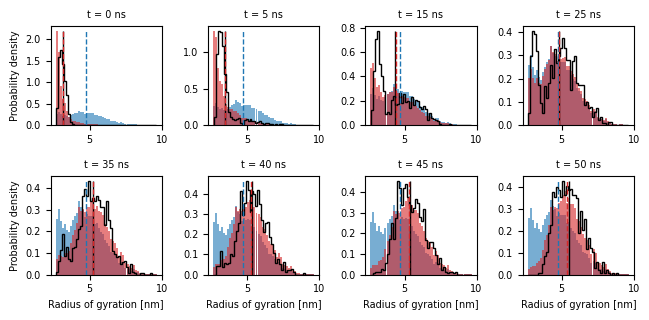

In [52]:
frames = [1,10,30,50,70,80,90,100]
label = 'Radius of gyration [nm]'
plot_histograms(rmetad, frames, bins, histr_uni, rgexp, rgav, label, si_fig_out_dir+'/hist_rg_uniform_prior.pdf', prior_dim=0)

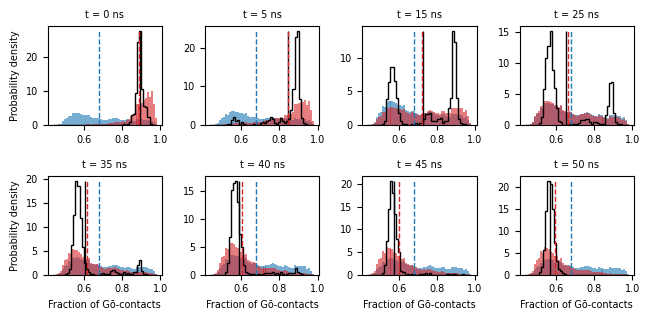

In [53]:
frames = [1,10,30,50,70,80,90,100]
label = 'Fraction of Gō-contacts'
plot_histograms(qmetad, frames, bins, histq_uni, qexp, qav, label, si_fig_out_dir+'/hist_q_uniform.pdf', prior_dim=0)

### SAXS fits

We can use the results of reweighting to see how the fit of SAXS data look like. To build the prior SAXS intensity, we average the MetaD intensities using the MetaD weights.

(101, 1000)


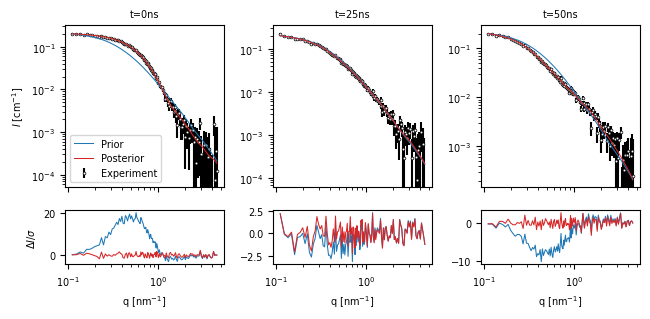

In [54]:
#uniform prior#
data = np.loadtxt(msaxs)

frames = [1, 50, 100]
fig,ax = plt.subplots(2,len(frames), figsize=(6.6, 3.3), sharex=True,gridspec_kw={'height_ratios': [3, 1]})
#thidx = [thetas.index(50)]*3
thidx=None
#rw[key].plot_saxs_fits(frames, thidx, rw[key].w0, outfig='metad_saxs.png')
#exp_data = np.vstack((qexp, qav, qstd)).T
print(qexp.shape)
#    plt.plot(intensity[:,0], intensity[:,1], c=cmap.to_rgba(i/2)) ,data, rw[key].res['w'], rw[key].w0)#, outfig='metad_saxs.png')
for i,f in enumerate(frames):
    intensity = gs.quick_load( f"{exp_int}/intensity_{f}.dat")
    #plt.plot(intensity[:,0], intensity[:,1], c=cmap.to_rgba(i/2))  
    plot_saxs_fits(ax[0,i], data,intensity, np.array(rw["uniform"].res['w'])[f,0,:],
                   w0=np.ones_like(np.array(rw["uniform"].res['w'])[f,0,:]),
                    residuals=True, res_ax=ax[1,i])
ax[1,0].set_ylabel(r'$\Delta I/\sigma$')
ax[0,0].set_ylabel(r'$I$ [cm$^{-1}$]')
ax[0,0].legend()
[ax[0,i].set_title(f't={int(frames[i]/2)}ns') for i in range(3)]
#def plot_saxs_fits(data, exp, w, w0):
plt.tight_layout()
#plt.savefig('saxs_fits_uniform_prior.pdf')
plt.show()
#__exp_ints

In [55]:
#Histograms
bins = 50
histq_uniform = rw[key].pdens_per_frame(qmetad, rw[key].theta_idxs, w0, bins=bins)
histr_uniform = rw[key].pdens_per_frame(rmetad, rw[key].theta_idxs, w0, bins=bins)
histm_uniform = rw[key].pdens_per_frame(rmsdmetad, rw[key].theta_idxs, w0, bins=bins)

In [56]:
stats_rg_uniform = hist_diff_statistics(rmetad, rgexp, histr_uniform, bins, start=1, stop=101)
stats_q_uniform = hist_diff_statistics(qmetad, qexp, histq_uniform, bins, start=1, stop=101)
stats_rm_uniform = hist_diff_statistics(rmsdmetad, rmexp, histm_uniform, bins, start=1, stop=101)

In [57]:
rmsf = []
for i in range(1,101):
    traj1 = md.load(data_dir+'/'+f'ensemble_trajs/md_{i}.xtc', top=data_dir+'/'+'data/bsa_ca.pdb')
    rmsf_md = md.rmsf(traj1, top_trj)
    rmsf_metad = weighted_rmsf(metad_trj, top_trj, rw[key].res['w'][i][theta_idxs[i]])
    rmsf_diff = np.average(np.fabs(rmsf_md - rmsf_metad)/rmsf_md * 100)
    rmsf.append(rmsf_diff)
av_rmsf = np.average(rmsf)
err_rmsf = np.std(rmsf)/np.sqrt(len(rmsf))

tmpq = np.fabs(qav - histq_metad['avrw'])/qav * 100
tmpr = np.fabs(rgav - histr_metad['avrw'])/rgav * 100
tmpm = np.fabs(rmav[1:] - histm_metad['avrw'][1:])/rmav[1:] * 100
diff_avq = np.average(tmpq)
diff_errq = np.std(tmpq)/np.sqrt(len(tmpq))
diff_avr = np.average(tmpr)
diff_errr = np.std(tmpr)/np.sqrt(len(tmpr))
diff_avm = np.average(tmpm)
diff_errm = np.std(tmpm)/np.sqrt(len(tmpm))

averages_metad = {'Rg':[diff_avr, diff_errr], 'Q':[diff_avq, diff_errq], 'RMSD':[diff_avm, diff_errm],
                 'RMSF':[av_rmsf, err_rmsf]}

print("# METAD POSTERIOR")
print("# ---------------")
print(f"# Delta <Rg>:           {diff_avr:.1f} +- {diff_errr:.1f}%")
print(f"# Delta <Q>:            {diff_avq:.1f} +- {diff_errq:.1f}%")
print(f"# Delta <RMSD>:         {diff_avm:.0f} +- {diff_errm:.0f}%")
print(f"# Delta <RMSF>:         {av_rmsf:.0f} +- {err_rmsf:.0f}%")

# METAD POSTERIOR
# ---------------
# Delta <Rg>:           1.4 +- 0.1%
# Delta <Q>:            13.6 +- 0.7%
# Delta <RMSD>:         17 +- 2%
# Delta <RMSF>:         7 +- 1%


In [58]:
#method_comp_dict = {}
pr_dist = []
rw_dist = []
for i,t in enumerate(np.linspace(0,50, nframes)):
    if i==0: continue
    he = np.histogram( qexp[i], bins = 50, density = True,range=(qmetad.min(),qmetad.max()) ) 
#                 linewidth = 2, color = 'k', zorder=3, range=(obs.min(),obs.max()) )
    dist_q = distances(histq_uniform['hrw'][i],he[0])
    #plt.scatter(t,dist_q['js'], color = 'tab:red')
    rw_dist.append(dist_q['js'])
    
    he = np.histogram( qexp[i], bins = 50, density = True,range=(qmetad.min(),qmetad.max()) ) 
#                 linewidth = 2, color = 'k', zorder=3, range=(obs.min(),obs.max()) )
    dist_q = distances(histq_uniform['hpr'][0], he[0])
    #plt.scatter(t,dist_q['js'], color = 'tab:blue')
    pr_dist.append(dist_q['js'])
#dist_q = distances(histq_metad['hpr'], he[0])
    #plt.scatter(t,dist_q['js'], color = 'tab:blue')
    #pr_dist.append(dist_q['js'])
method_comp_dict[key] = {'prior':pr_dist, 'post':rw_dist}  


In [59]:
U, I, F = rw['uniform'].populations(qmetad, icutmx, icutmn, rw['uniform'].res['w'], rw['uniform'].theta_idxs)
clustering['uniform'] = [U, I, F]

# Comparison

dyn orange
metad tab:grey
uniform dodgerblue


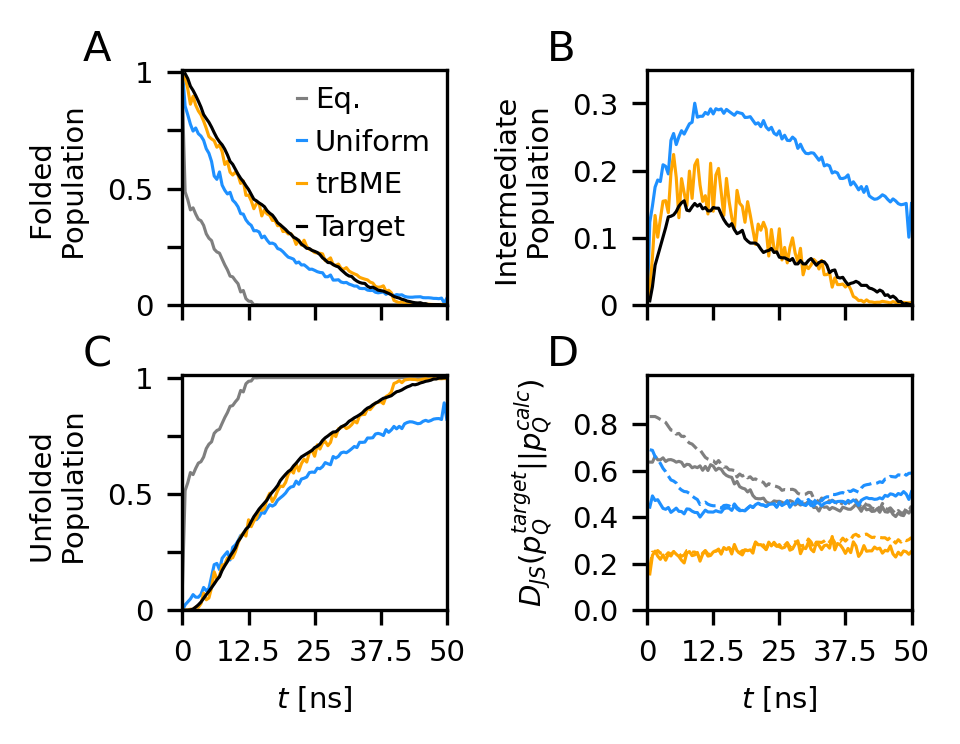

"\nx = np.linspace(0, 50, nframes)\nfig,ax = plt.subplots(1,3, figsize=(15, 5),\n                      sharey='row', constrained_layout=True)#,gridspec_kw={'height_ratios': [3.5, 1,4,4]},\nax[0].plot(x[1:], F[1:], lw=2, c='#011f4b', label='Folded')\nax[1].plot(x[1:], I[1:], lw=2, c='#005b96', label='Intermediate')\nax[2].plot(x[1:], U[1:], lw=2, c='#b3cde0', label='Unfolded')\nax[0].set_xlabel('Time [ns]')\nax[1].set_xlabel('Time [ns]')\nax[2].set_xlabel('Time [ns]')\n\nax[0].set_ylabel('Population')\nax[0].legend()\nplt.tight_layout()\nplt.savefig('pics/clustering.png', dpi=300)\n"

In [61]:
#style_path = "/Users/vjc493/Documents/mpl_style/custom.mplstyle"
#plt.style.use(style_path)

#what happened to method comp dict 

fig, ax = plt.subplots(2,2,dpi=300,figsize=(3.3,3.3*0.75), sharex='col')
for ak in ax.flatten():
    #if ak==ax[1,1]:ak.grid(color = 'k', ls='--')
    ak.set_xticks([0, 12.5, 25, 37.5,50],['0', '12.5', '25', '37.5','50'] )#,['0', '', '25', '','50'])

#ax = fig.add_subplot(gs[0, :])
#fig = plt.figure(figsize=(15,10))

for ls_val, method, method_name in zip(['orange', 'tab:grey', 'dodgerblue'] 
                                       ,method_comp_dict.keys(),
                                      ['Dynamical Prior', 'MetaD Prior', 'Uniform Prior']):
#for ls_val, metod in zip(['dotted'], ['uniform']): 
#for method in ['uniform']:
    print(method, ls_val)
    method_d = method_comp_dict[method].copy()
    #if method=='metad':
    #    ls_val = 'dashed' 
    #else:
    #    ls_val = 'solid'
    ax[1,1].plot(np.linspace(0.5,50, nframes-1), method_d['prior'], color=ls_val
             ,ls='--', lw=0.75)#,markeredgecolor='tab:blue',marker=mark,ms=3, )
    ax[1,1].plot(np.linspace(0.5,50, nframes-1), method_d['post'], color=ls_val,
              lw=0.75, label = method_name)#,markeredgecolor='tab:red',marker=mark,ms=3, )
    
    #color='w', ecolor='k',
         #        markeredgecolor='k', ms=5, label='Experiment', zorder=0
ax[1,1].set_xlabel('$t$ [ns]')#, fontsize=10)#, fontsize=25)
#plt.ylabel(r'$\Delta h_{true, calc}$')#, fontsize=25)
ax[1,1].set_ylabel(r'$D_{JS}(p^{target}_Q||p^{calc}_Q)$')#set_ylabel(r'$D_{\textsf{JS}}(p^{\textsf{Target}}_Q||p^{\textsf{Calc}}_Q)$')#, fontsize=10)#(r'$D_{JS}(p(Q)_{calc}||p(Q)_{true})^{1/2}$', fontsize=15)

#ax[1,1].set_xticks([0, 10, 20, 30, 40, 50])#, fontsize=5)
#custom_ticks = ['']*(10)
#custom_ticks[0] = '0'
#custom_ticks[5] = '25'
#custom_ticks[9] = '50'
#ax[1,1].set_xticks([0, 12.5, 25, 37.5,50],['0', '12.5', '25', '37.5','50'] )#,['0', '', '25', '','50'])

#ax[1,1].set_xticks(np.arange(0,50,5), custom_ticks)#, ['0','','25','',50])#,fontsize=5)#fontsize=20)
#[]
ax[1,1].set_yticks([0, 0.2, 0.4, 0.6, 0.8])#, fontsize=5)

#plt.grid()
plt.ylim(0, 0.89)
plt.xlim(0, 50)


#plt.legend( ncol=3, fontsize=7)#, fontsize=5) #loc="lower left"

x = np.linspace(0,50,101)

#g_spc_2 = fig.add_gridspec(3,1, hspace=0, wspace=0)
#(ax1, ax2, ax3) = g_spc_2.subplots(sharey='row')

#plt.subplot(3,3,4)
#5e498c
#c04889
#fe625b
#ffa600
#plt.grid()

#ax[0,0].set_title('Folded')#, fontsize=10)
ax[0,0].set_xlim(0, 50)

ax[0,0].plot(x, clustering['metad'][2], lw=0.75, c='tab:grey', label=f'Eq.', ls='-',ms=0.5)
ax[0,0].plot(x, clustering['uniform'][2], lw=0.75, c='dodgerblue', label=f'Uniform', ls='-',ms=0.5)
ax[0,0].plot(x, clustering['dyn'][2], lw=0.75, c='orange', label=f'trBME', ls='-',ms=0.5)
ax[0,0].plot(x[1:], clustering['exp'][2][1:], lw=0.75, c='k', label='Target')
#plt.xlabel('Time [ns]')#, fontsize=25)
ax[0,0].set_ylabel('Folded \n Population')#, fontsize=10)
#plt.yticks()#fontsize=20)
#ax[0,0].set_xticks([0,12.5,25,37.5, 50], ['0','','25','',50])#,fontsize=5)
ax[0,0].set_yticks([0,0.25,0.5,0.75,1], ['0','','0.5','',1])#,fontsize=5)
ax[0,0].legend(loc='upper right',frameon=False, fancybox=False, framealpha=1,
               edgecolor='k', handlelength=0.3, borderpad=0.05, handletextpad=0.3)#fontsize=5)
#lgnd.legend_handles[0]._sizes = [2]
#ax[0,0].grid()
ax[0,0].set_ylim(0,1.01)

#plt.grid(zorder=0)

#ax[0,1].set_title('Intermediate')#, fontsize=10)

ax[0,1].set_xlim(0, 50)

ax[0,1].plot(x, clustering['metad'][1], lw=0.75, c='tab:grey', label=f'Metad posterior', ls='-',ms=0.5, )#, markersize=0.5)
ax[0,1].plot(x, clustering['uniform'][1], lw=0.75, c='dodgerblue', label=f'Uniform posterior', ls='-',ms=0.5, )#, markersize=0.5)
ax[0,1].plot(x, clustering['dyn'][1], lw=0.75, c='orange', label=f'Dynamical posterior', ls='-',ms=0.5, )#, markersize=0.5)
ax[0,1].plot(x[1:], clustering['exp'][1][1:], lw=0.75, c='k', label='Experimental' )
#plt.xlabel('Time [ns]')#, fontsize=25)
ax[0,1].set_ylabel('Intermediate \n Population')
#plt.yticks([0,0.15,0.3])#fontsize=20)
#ax[0,1].set_xticks([0,12.5,25,37.5, 50], ['0','','25','',50])#,fontsize=5)#fontsize=20)
ax[0,1].set_yticks([0,0.1,0.2,0.3], ['0','0.1','0.2','0.3'])#,fontsize=5)#fontsize=20)
#plt.xaxis.set_ticks_position('none')
#plt.xticks([0,25, 50])#fontsize=20)
#plt.ylim(0,1)
#plt.legend()
#ax[0,1].grid()
ax[0,1].set_xlim(0, 50)

#ax[0,1].set_ylim(0,1.01)
ax[1,0].set_ylim(0,1.01)
ax[0,1].set_ylim(0,0.35)
ax[1,1].set_ylim(0,1.01)
#ax[1,0].set_title('Unfolded')#, fontsize=10)
#plt.grid()
ax[1,0].set_ylabel('Unfolded \n Population')#, fontsize=10)
ax[1,0].set_xlabel('$t$ [ns]')#, fontsize=10)#, fontsize=25)

ax[1,0].plot(x, clustering['metad'][0], c='tab:grey', label=f'Metad posterior',  ls='-',lw=0.75)
ax[1,0].plot(x, clustering['uniform'][0], c='dodgerblue', label=f'Uniform posterior', ls='-',lw=0.75)
ax[1,0].plot(x, clustering['dyn'][0], c='orange', label=f'Dynamical posterior',  ls='-',lw=0.75)
ax[1,0].plot(x[1:], clustering['exp'][0][1:], c='k', label='Experimental', lw=0.75)
#plt.xlabel('Time [ns]')#, fontsize=25)
#plt.ylabel('Population', fontsize=25)
#ax[1,0].set_xticks([0,12.5,25,37.5, 50], ['0','','25','',50])#,fontsize=5)#fontsize=20)
ax[1,0].set_yticks([0,0.25,0.5,0.75,1], ['0','','0.5','',1])#,fontsize=5)#fontsize=20)
#ax[1,0].grid()

#plt.subplots_adjust(wspace=0, hspace=0)
#plt.legend()
#plt.constrained_layout = True
#plt.tight_layout()

#ax[1,1].text(syx, syy,'here', fontsize = 50 )
#ax[1,1].text(syx, syy,'here', fontsize = 50 )
#ax[1,1].text(-20, syy,'here', fontsize = 50 )

fig.tight_layout()


#for idx, label in zip([[0,0],[1,0],[0,1],[1,1]],[r'$\bf{\sf{A}}$', r'$\bf{\sf{B}}$', r'$\bf{\sf{C}}$', r'$\bf{\sf{D}}$']):
#    print(idx[0],idx[1], label)
#    ax[idx[0], idx[1]].text(0, 1.15, label, transform=ax[idx[0], idx[1]].transAxes,
#    fontsize=10, va='top', ha='right', c='r')
label_s = ['A', 'B', 'C', 'D']#[r'\textsf{\textbf{A}}', r'\textsf{\textbf{B}}', r'\textsf{\textbf{C}}', r'\textsf{\textbf{D}}']

for label, aks in zip(label_s, ax.flatten()):
    # label physical distance to the left and up:
    #trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    trans = mtransforms.ScaledTranslation(-24/72, 0/72, fig.dpi_scale_trans)

    aks.text(0.0, 1.0, label, transform=aks.transAxes + trans,
            va='bottom', fontsize=10, 
            )
      #fontsize=16, fontweight='bold', va='top', ha='right'
#**{"font.family": "Computer Modern Sans Serif", "text.usetex" :False}
#plt.savefig('main_figs_new/performance_2v4.pdf', dpi=600,bbox_inches="tight")
#plt.savefig('main_figs_new/performance_2v4.svg', dpi=600,bbox_inches="tight")

plt.savefig('main_figures_pdf/performance_2v2.1.png', dpi=600)
plt.show()


# = fig.add_gridspec(2, 2, hspace=0, wspace=0)
#(ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')
'''
x = np.linspace(0, 50, nframes)
fig,ax = plt.subplots(1,3, figsize=(15, 5),
                      sharey='row', constrained_layout=True)#,gridspec_kw={'height_ratios': [3.5, 1,4,4]},
ax[0].plot(x[1:], F[1:], lw=2, c='#011f4b', label='Folded')
ax[1].plot(x[1:], I[1:], lw=2, c='#005b96', label='Intermediate')
ax[2].plot(x[1:], U[1:], lw=2, c='#b3cde0', label='Unfolded')
ax[0].set_xlabel('Time [ns]')
ax[1].set_xlabel('Time [ns]')
ax[2].set_xlabel('Time [ns]')

ax[0].set_ylabel('Population')
ax[0].legend()
plt.tight_layout()
plt.savefig('pics/clustering.png', dpi=300)
'''